In [1]:
'''
(train and test)
1.Cut tha retina / compare the sizes of the cutted images with its original size to verify if too many images didnt change
2.Resize 512×512   / interpolate adding a black framework in order to dont distorsionate the image
3.Histogram equalization
5.mean subsraction and normalization
6.delete corrupted images
7. Save the array with all the modified images 
'''
import os
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
from PIL import Image
import cv2
import cv2.cv as cv
import math
import retinaMethods as rm
from numpy import genfromtxt
import paths_file

In [2]:
path = paths_file.train_orig_path #'../Original-Retina-Data/KaggleD/train/'

#Get images names
all_imag = os.listdir(path)

#Sort the files names to be according with the name file
rm.sort_nicely(all_imag) 

In [3]:
#LOAD THE LABELS 

my_data = genfromtxt(paths_file.train_labels_path, delimiter=',')
labelsNum = my_data[1:,1] #Remove the first row, and take the second column
labelsNum = labelsNum.astype('uint8')

prob = []
print("Original data distribution:")
for k in range(5):
    print(np.sum(labelsNum==k)/float(labelsNum.size)*100)
    prob.append(np.sum(labelsNum==k)/float(labelsNum.size))

prob = np.array(prob)
n2 = 1./np.min(prob)    #The maximum value that I can have is 1/minimum

Original data distribution:
73.4783351364
6.95496213631
15.0657632523
2.4853384957
2.01560097933


In [4]:
all_imag.index('320_left.jpeg') #320_left + 20 --> contiene todas las clases

272

In [5]:
# all_imag = all_imag[272:272+20]
# labelsNum = labelsNum[272:272+20]

all_imag = all_imag[0:20]
labelsNum = labelsNum[0:20]

In [6]:
print(all_imag, labelsNum)

['10_left.jpeg', '10_right.jpeg', '13_left.jpeg', '13_right.jpeg', '15_left.jpeg', '15_right.jpeg', '16_left.jpeg', '16_right.jpeg', '17_left.jpeg', '17_right.jpeg', '19_left.jpeg', '19_right.jpeg', '20_left.jpeg', '20_right.jpeg', '21_left.jpeg', '21_right.jpeg', '22_left.jpeg', '22_right.jpeg', '23_left.jpeg', '23_right.jpeg'] [0 0 0 0 1 2 4 4 0 1 0 0 0 0 0 0 0 0 0 0]


In [7]:
image_list = []
for i in xrange(len(all_imag)):
    im=cv2.imread(os.path.join(path, all_imag[i]))     
    image_list.append(im)

    
print("Amount of images: " , len(image_list))

Amount of images:  20


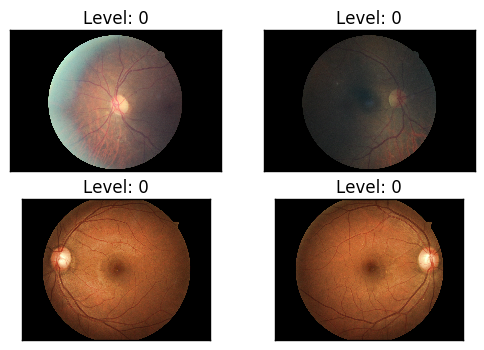

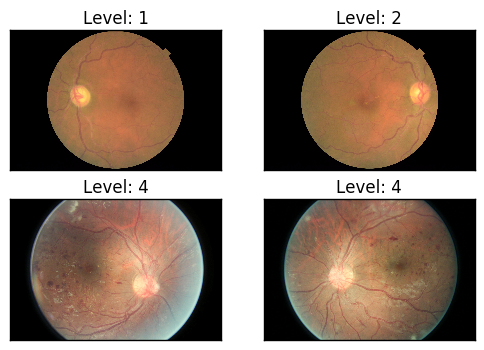

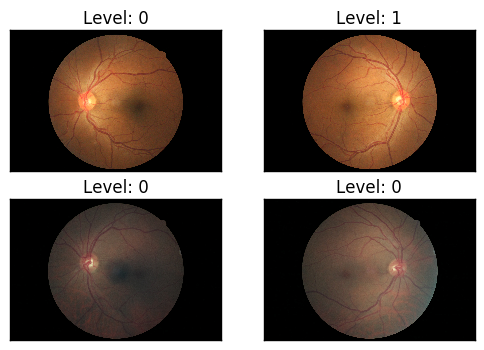

In [8]:
array = []

amIm = 4
offset= 0 

stops = np.arange(0,12,4)

for k in np.arange(stops.shape[0]):
    offset= stops[k]

    for i in xrange(amIm):
        img = image_list[i+offset]
        img = img[:,:,::-1]
        array.append(img)

        plt.subplot(math.ceil(amIm/2.0),2,i+1)

        plt.imshow(img)
        plt.title("Level: " + str(labelsNum[i+offset]))
        plt.xticks([]),plt.yticks([])
    plt.show()

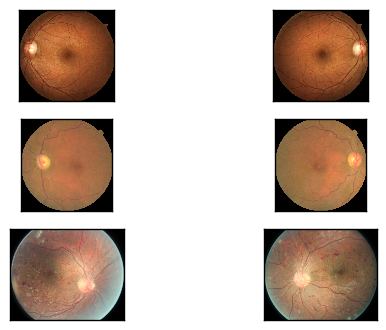

In [16]:
#CUT THE IMAGES
def cutRetina(img):
    "Cuttig"
    #img = image_list[60]
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) #gray = img.convert('L') 

    #gray = np.asarray(gray)

    #plt.imshow(gray,cmap='gray')
    #plt.show()


    r, c  = gray.shape

    thresh = 5

    r1 = 0; c1 = 0; r2 = r; c2 = c
    
    #print ("r1---------------")
    for i in xrange(r/2, 0, -1):
        if np.mean(gray[i,:]) <= thresh:
            r1 = i
            break
    #print ("c1----------------------")
    for i in xrange(c/2, 0, -1):
        if np.mean(gray[:,i]) <= thresh:
            c1 = i
            break
    #print ("r2----------------------")
    for i in xrange(r/2, r, 1):
        if np.mean(gray[i,:]) <= thresh:
            r2 = i
            break

    #print ("c2----------------------")
    for i in xrange(c/2, c, 1):
        if np.mean(gray[:,i]) <= thresh:
            c2 = i
            break
    corpIm = img[r1:r2,c1:c2]  #corpIm= img.crop((c1, r1, c2 , r2 )) #x,y,x2,y2

    #BGR to RGB --> OpenCV image to Matplotlib
    corpIm = corpIm[:,:,::-1]

    #plt.imshow(corpIm)
    #plt.show()
    return corpIm

array = []

amIm = 6
offset= 2

for i in xrange(amIm):
    outp = cutRetina(image_list[i+offset])
    array.append(outp)
    plt.subplot(math.ceil(amIm/2.0),2,i+1),plt.imshow(array[i])
    plt.xticks([]),plt.yticks([])


Original shape:  (2592, 3196, 3)
Square shape:  (3196, 3196, 3)


(302, 302, 0, 0)

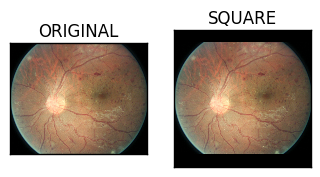

In [10]:
#MAKE THE IMAGE A SQUARE ADDING ZEROS AT THE MATRIX

img1 = array[1]

#Initial conditions
top = bottom = left = rigth = 0

BLACK = [0,0,0]
h, w , _ = img1.shape
dif = abs(h-w)

#Verify in witch senses add the border
if dif != 0:
    if h > w:
        #Needs to add in left-rigth
        left = dif/2
        rigth  = dif/2 + (dif % 2) 
    else:
        #Needs to add in top-bottom
        top = dif/2
        bottom  = dif/2 + (dif % 2)  



print("Original shape: ", img1.shape)
constant= cv2.copyMakeBorder(img1,top,bottom,left,rigth,cv2.BORDER_CONSTANT,value=BLACK)
print("Square shape: ",constant.shape)

plt.subplot(231),plt.imshow(img1,'gray'),plt.title('ORIGINAL')
plt.xticks([]),plt.yticks([])
plt.subplot(232),plt.imshow(constant,'gray'),plt.title('SQUARE')
plt.xticks([]),plt.yticks([])

top,bottom,left,rigth

Original shape: (3196, 3196, 3)
Resized shape: (512, 512, 3)


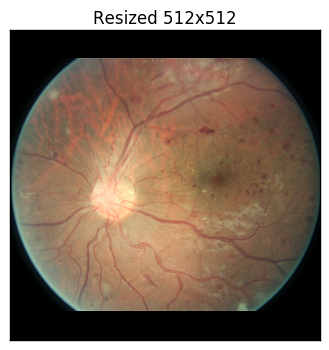

In [11]:
#RESIZE THE IMAGES
img_rows = img_cols = 512

croppedIm = constant
print("Original shape:" , croppedIm.shape)
resizedIm = cv2.resize(croppedIm,(img_rows, img_cols), interpolation =  cv2.INTER_CUBIC )
print("Resized shape:" , resizedIm.shape)


plt.imshow(resizedIm),plt.title('Resized 512x512')
plt.xticks([]),plt.yticks([])
plt.show()


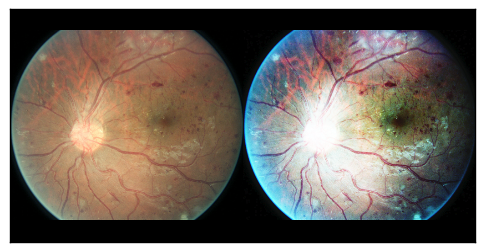

0
255


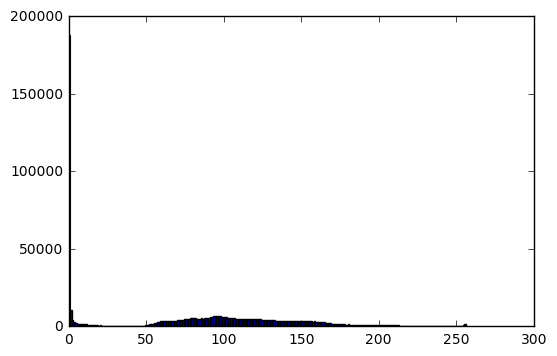

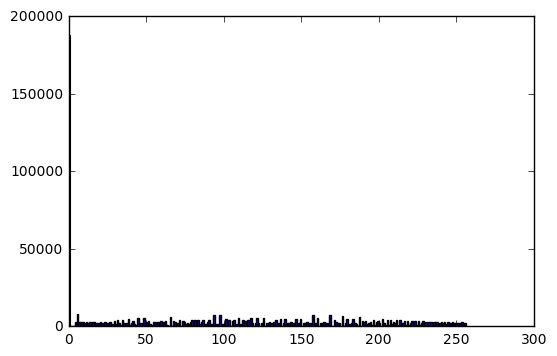

In [18]:
#HISTOGRAM EQUALIZATION

ori =  resizedIm
    
img = ori.copy()

#Equialize each chanel
img[:, :, 0] = cv2.equalizeHist(img[:, :, 0]) 
img[:, :, 1] = cv2.equalizeHist(img[:, :, 1]) 
img[:, :, 2] = cv2.equalizeHist(img[:, :, 2]) 

res = np.hstack((ori,img)) #stacking images side-by-side

plt.imshow(res)
plt.xticks([]),plt.yticks([])
plt.show()

print(np.min(img))
print(np.max(img))
plt.hist(ori.ravel(),256,[0,256]); plt.show()
plt.hist(img.ravel(),256,[0,256]); plt.show()


(512, 512, 3)


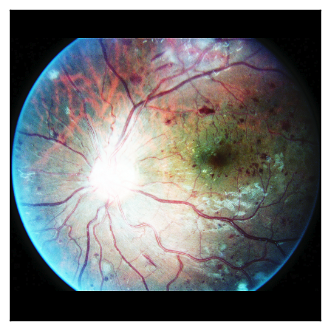

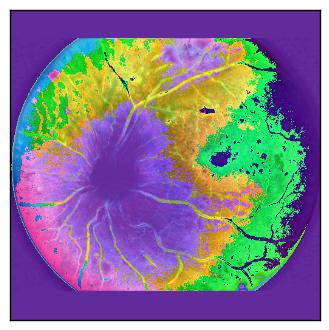

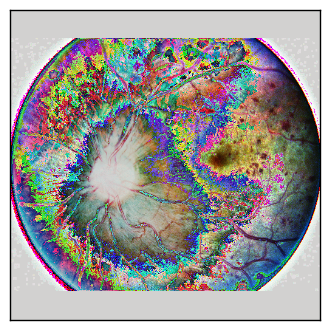

In [13]:
#CENTRED THE DATA AND NORMALIZATION

mean_RGB = [100.009405273 ,100.227072634 , 100.786751717] 
std_RGB = [84.3177751745 , 84.2576168412, 84.4614340298]
#len(image_list)
#img = img

#img = img.convert('L')
#print("image" , img)     

#PIL image to numpy
I = img #I = np.asarray(img) 
print(I.shape)

plt.imshow(I)
plt.xticks([]),plt.yticks([])
plt.show()

#Mean subtraction -> cero centered data
# Y = I- np.mean(I)
#I -= np.mean(I)

#Normalization
#I /= np.std(I, axis = 0)
# X = Y /np.std(Y)

X_train = img
X_train = X_train.astype('float32')

X_train[:,:,0] = X_train[:,:,0] - mean_RGB[0]
X_train[:,:,1] = X_train[:,:,1] - mean_RGB[1]
X_train[:,:,2] = X_train[:,:,2] - mean_RGB[2]


plt.imshow(X_train)
plt.xticks([]),plt.yticks([])
plt.show()


Y = X_train

Y[:,:,0] = Y[:,:,0]/std_RGB[0]
Y[:,:,1] = Y[:,:,1]/std_RGB[1]
Y[:,:,2] = Y[:,:,2]/std_RGB[2]


plt.imshow(Y)
plt.xticks([]),plt.yticks([])
plt.show()


#----------------------------------------------------------------------------------
#PLOTTING

# images = [I, X_train ,Y ]

# for i in xrange(len(images)):
#     plt.subplot(math.ceil(len(images)/2.0),2,i+1),plt.imshow(images[i])
#     plt.xticks([]),plt.yticks([])

In [14]:
#--------------------------------------------------------------------------------------------------------------------